Check Python version

In [5]:
!python --version

Python 3.10.6


Import libraries

In [6]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [7]:
file_name = '../datasets/climate/temp_anom_w_forcing.csv'

In [8]:
dataset = pd.read_csv(file_name)

In [9]:
dataset.shape

(163, 11)

In [10]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [11]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [12]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


Define the required time and target columns

In [13]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [14]:
# dataset[target_col] = dataset[target_col].astype(float)

In [15]:
# dataset.head()

Split dataset into train and test sets

In [16]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

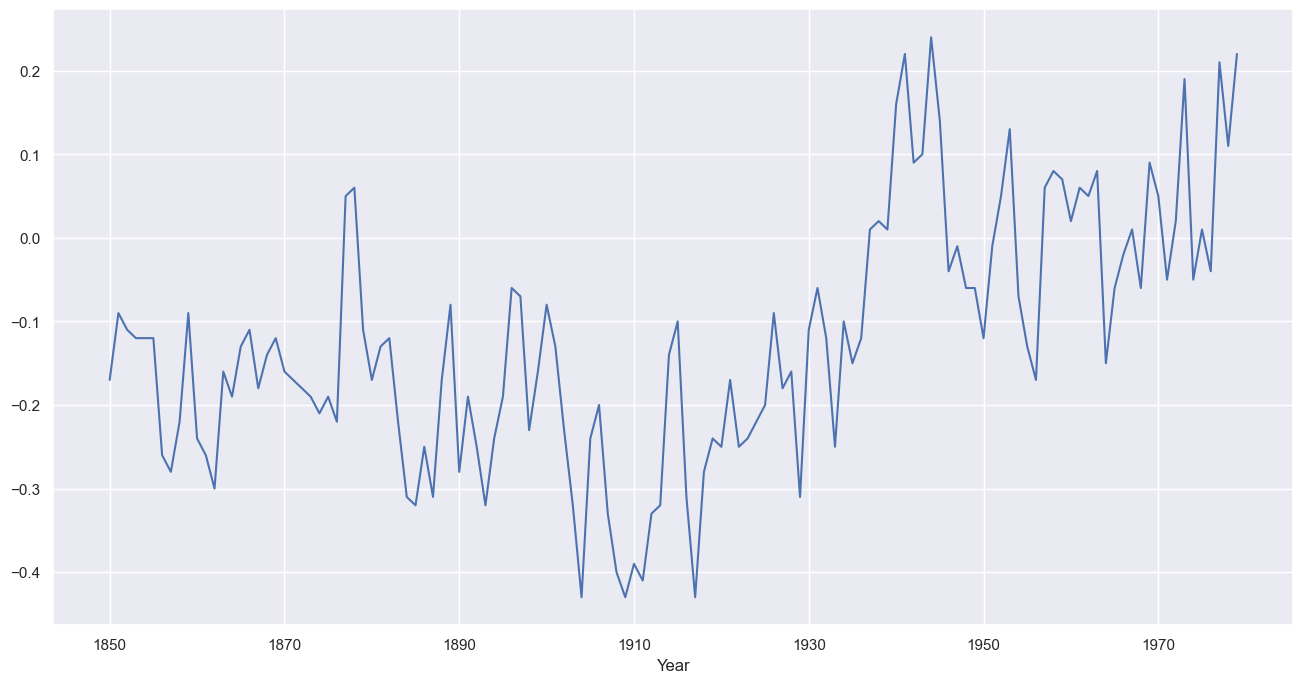

In [17]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [18]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [19]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [20]:
# Default model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_wa'
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_autoets'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'param': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [21]:
api_json = {
    'data': train_data,
    # 'model': model_request  # (optional) can be commented out
}

Build URL

In [22]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [23]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [24]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [25]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 0 ns
Wall time: 38.1 s


In [26]:
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [27]:
train_json_out

{'model': 'AgEBCCz5AQAo+QEAOZMBABgAAAAxkwEAfDIAAD+AAC5wlGmUYXJhbG+MSZOMZ25fEmNpcoFtbmVhZ2ljch1dYWlibnhuZXNjNJR0cG1hY3RtYUuHCXQCUpT/dADAAB+UlF2FKC6HMv90tX3zx6fmo9yBlB9ohwkBAgMEBQYHCB8JlIYGfXNvlGVnjG5jCWFfZV9hBZRzbGxhaGmUc3JhlBAobGdwbGUPbJQAlIaUS07/icBY4IEAB5RLS12US1KU4ACRH5RSYWlkc19llGVlaGEujHVfQpRzcnSMbZOHTZRO/0MBAJSBER99S4YEfoiR6vT9B2Bpc33V3+nzS1VfacHL1d83QUtVrR+3wcojLTdAmaOstg8YIiyFjpii+gQOGCIsNT+Yoau1DR8XISuDjZeh+QMNF295g43l7/kCW2VveNHb5O5HUFpkvR/G0NoyPEZQqLK8xh4oMjyUnqiyChQeJ4CKk532AAkTbBZ1f4nh6/WUlIyGlGFfY2JpbJRueG59geEGnRAkKUtIAAC/vwAAv7/AaCGUS+EBgQo2fVGUaId0X2M2eOAMNghAPz8APz8/AD/gDzYfBRhlbHNNk4xvKERwgWFldHNzYmhlfXJydAtfX2+UdAofb3JycxBpc1OUCWl4ci5hYZSMcxRjaUlpKQWydHIuZ2EfbnJ9YZRoBmhfjGmUbwGUUQEpR4yTJClLT5RO/4lhAWofAlJOdE0AdWVkKHIulHOUjGghVZuUS4mlSOvdgCPGuFsf/qGTNtl8bhG0V0nsjzIkx2oN/6JF6Np9IMO1WPuekDMf1nlrDrFURumML9J1GLutUPOWiCvOcWMGqUw+4YQnGbwfXwL0lzrdz3IVuKpN8JOFKMtuYAOmSTvegSQWuVz/8ZQfN9rMbxK1p0rtkIIlyGtdAKNGONt+IRO2WZQbX2xzZZQfh2EFCmgDC3SGak4AfSeUhV10AIwAAYxOYQBhgQEAbAAfhSgBB

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [28]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [29]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [30]:
model = train_json_out['model']

Forecast API JSON Payload

In [31]:
api_json = {
    'model': model,
    'predicts': test_data
}

Build URL (same as train except for the endpoint)

In [32]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [33]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 15.6 ms
Wall time: 61.6 ms


In [34]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [35]:
forecast_json_out

{'data': [['1980-01-01T00:00:00', 0.37600865598626276],
  ['1980-12-31T00:00:00', 0.7472575374618879],
  ['1981-12-31T00:00:00', 0.6690394280778698],
  ['1982-12-31T00:00:00', 0.6583547568447969],
  ['1983-12-31T00:00:00', 0.45365035490575756],
  ['1984-12-30T00:00:00', 0.8448842742793365],
  ['1985-12-30T00:00:00', 0.7307628160025024],
  ['1986-12-30T00:00:00', 0.6710997322669976],
  ['1987-12-30T00:00:00', 0.5261687655664395],
  ['1988-12-29T00:00:00', 0.9094263394380597],
  ['1989-12-29T00:00:00', 0.7974373431960002],
  ['1990-12-29T00:00:00', 0.8144199914171824],
  ['1991-12-29T00:00:00', 0.6540705288361734],
  ['1992-12-28T00:00:00', 1.00241324543337],
  ['1993-12-28T00:00:00', 0.8521067214391314],
  ['1994-12-28T00:00:00', 0.8307841427911238],
  ['1995-12-28T00:00:00', 0.652882911520565],
  ['1996-12-27T00:00:00', 1.0075474686055477],
  ['1997-12-27T00:00:00', 0.9120942802362673],
  ['1998-12-27T00:00:00', 0.900046149898845],
  ['1999-12-27T00:00:00', 0.7322188249954555],
  ['200

Combine forecast dates and output

In [36]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [37]:
forecast_df.shape

(33, 2)

In [38]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [39]:
forecast_df.head()

,Year,Anomaly
0,1980-01-01T00:00:00,0.376009
1,1980-12-31T00:00:00,0.747258
2,1981-12-31T00:00:00,0.669039
3,1982-12-31T00:00:00,0.658355
4,1983-12-31T00:00:00,0.453650


In [40]:
forecast_df.tail()

,Year,Anomaly
28,2007-12-25T00:00:00,0.863689
29,2008-12-24T00:00:00,1.228349
30,2009-12-24T00:00:00,1.098405
31,2010-12-24T00:00:00,1.100445
32,2011-12-24T00:00:00,0.930585


Plot train and forecast side-by-side

C:\Users\User\AppData\Local\Temp\ipykernel_20324\3069213585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


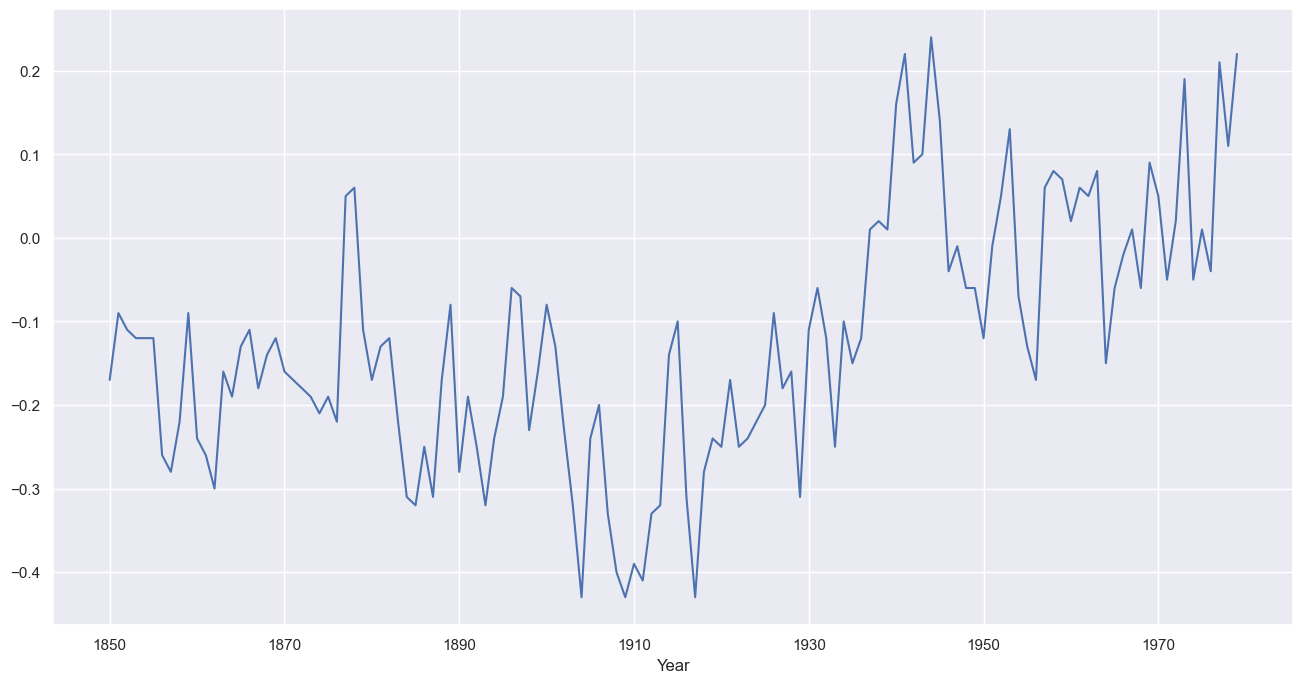

In [41]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

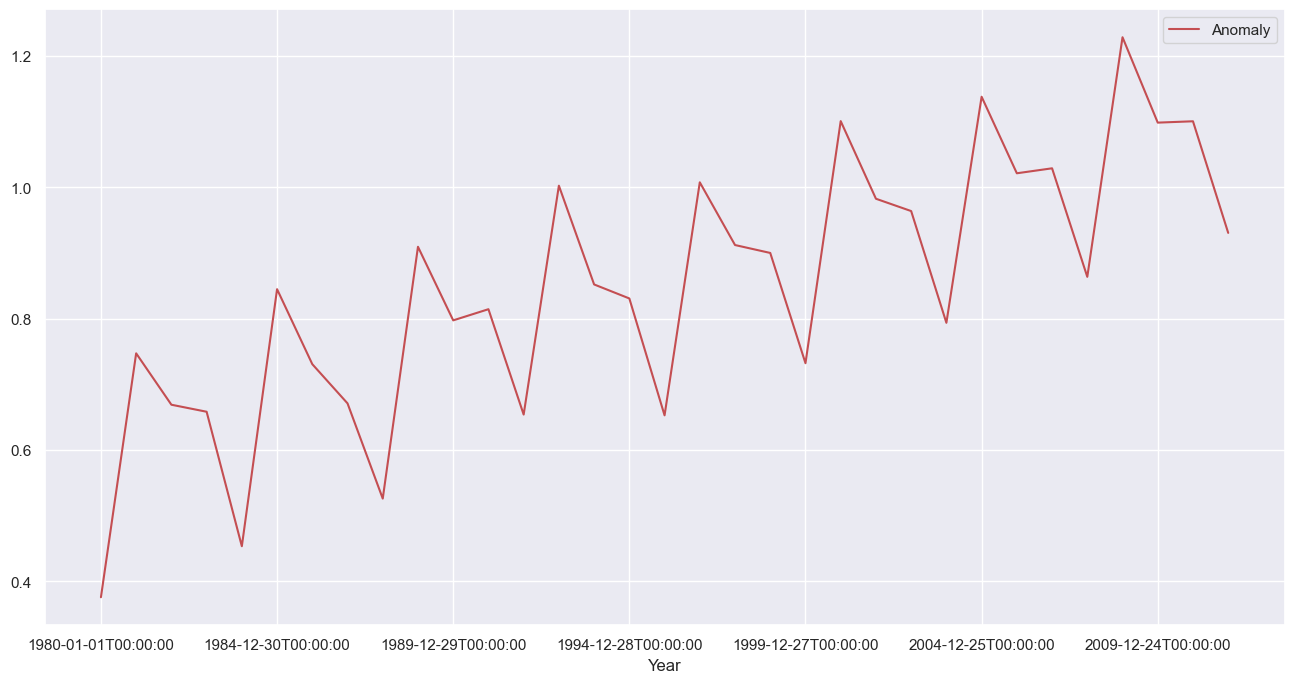

In [42]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [43]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [44]:
df.shape

(163, 12)

In [45]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [46]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
158,2007-12-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.863689,r
159,2008-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.228349,r
160,2009-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.098405,r
161,2010-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.100445,r
162,2011-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930585,r


Plot combined train and test sets with the vertical black line as the cut-off

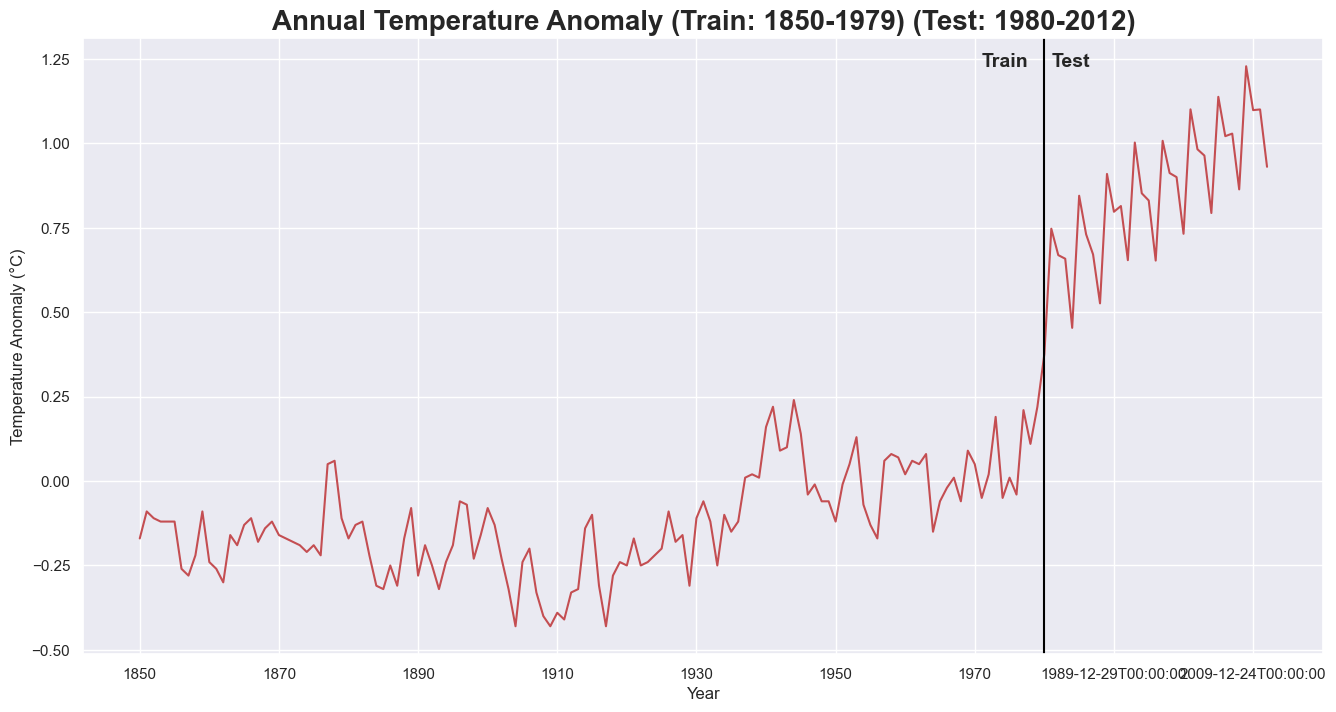

In [47]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

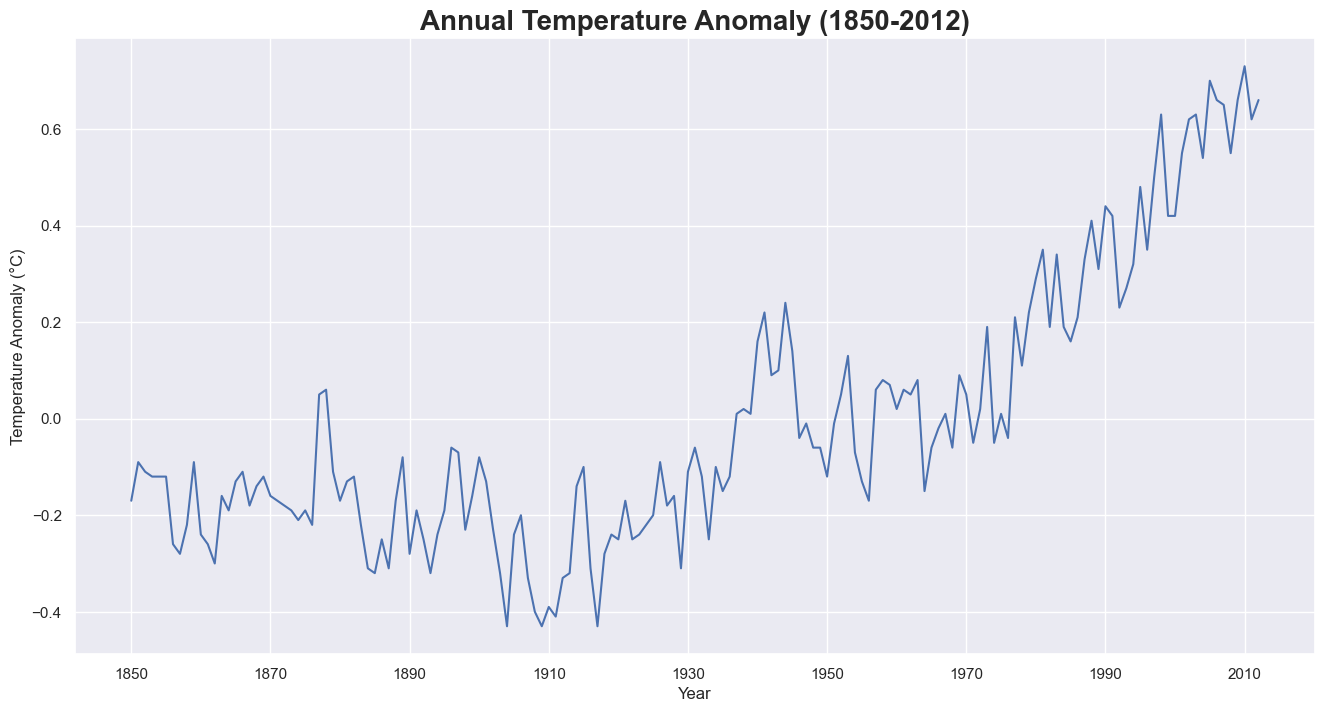

In [48]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

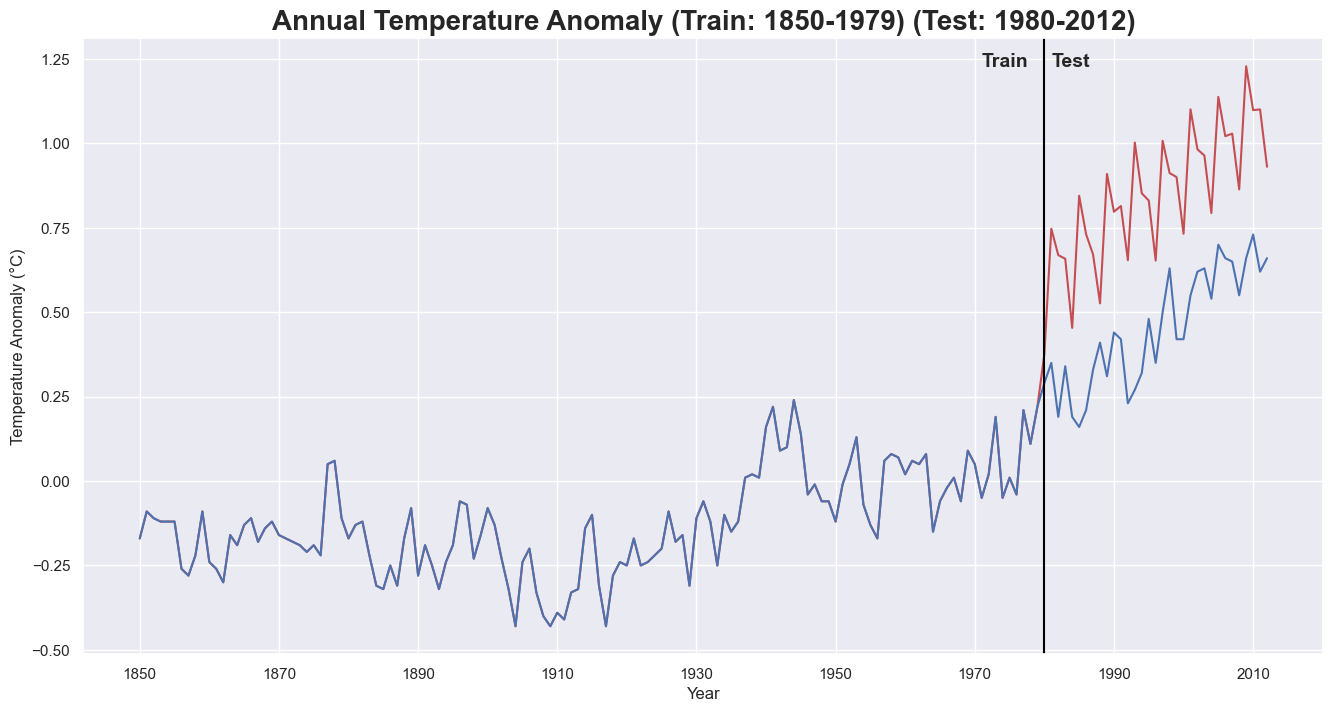

In [49]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();